## pre-pocessing

In [125]:
import pandas as pd
import json
import seaborn as sb
import numpy as np
from sklearn.cross_validation import train_test_split
from numpy import random
import gensim
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Word2Vec

## Import dataset

In [126]:
path = "dataset/"

In [127]:
df = pd.read_csv(path+"USvideos.csv")
df = df.assign(country="US")
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')  
df.trending_date = df.trending_date.dt.date   
df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
df=df.assign(publish_date=df['publish_time'].dt.date)
df['publish_time'] = df['publish_time'].dt.time

###导入category名称###
df=df.assign(cat_name='a')
id_to_category = {}
file=path+'US_category_id.json'
with open(file, 'r') as f:
    data=json.load(f)
    for category in data['items']:
        id_to_category[category['id']] = category['snippet']['title']
print(id_to_category)
###实际上每个国家的category id-name 字典是一样的
df['category_id'] = df['category_id'].astype(str)
df.insert(4, 'category', df['category_id'].map(id_to_category))

{'1': 'Film & Animation', '2': 'Autos & Vehicles', '10': 'Music', '15': 'Pets & Animals', '17': 'Sports', '18': 'Short Movies', '19': 'Travel & Events', '20': 'Gaming', '21': 'Videoblogging', '22': 'People & Blogs', '23': 'Comedy', '24': 'Entertainment', '25': 'News & Politics', '26': 'Howto & Style', '27': 'Education', '28': 'Science & Technology', '29': 'Nonprofits & Activism', '30': 'Movies', '31': 'Anime/Animation', '32': 'Action/Adventure', '33': 'Classics', '34': 'Comedy', '35': 'Documentary', '36': 'Drama', '37': 'Family', '38': 'Foreign', '39': 'Horror', '40': 'Sci-Fi/Fantasy', '41': 'Thriller', '42': 'Shorts', '43': 'Shows', '44': 'Trailers'}


## Clean Data

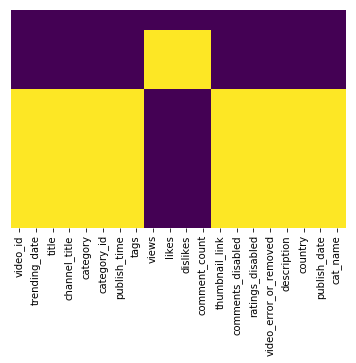

In [128]:
df_summary = df.describe(include="all")

# Use heatmap to check missing data
sb.heatmap(df_summary.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [129]:
# See counts of missing value
for c in df_summary.columns:
    print(c,np.sum(df_summary[c].isnull()))

video_id 7
trending_date 7
title 7
channel_title 7
category 7
category_id 7
publish_time 7
tags 7
views 3
likes 3
dislikes 3
comment_count 3
thumbnail_link 7
comments_disabled 7
ratings_disabled 7
video_error_or_removed 7
description 7
country 7
publish_date 7
cat_name 7


In [130]:

df.sample(5)
# Replace missing data
df_summary['description'].fillna("", inplace=True)
df_summary['title'].fillna("", inplace=True)
df_summary['category_id'].fillna(0, inplace=True)


# for k,v in df_summary.items():
#     print(type(df_summary[k]))
#     print("hhh")
#     df_summary[k].fillna(int(df_summary[k].mean()), inplace=True)

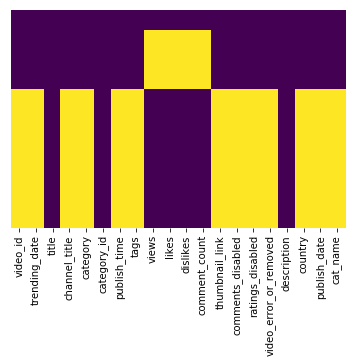

In [131]:
# Drop a column most value are missing
# df_summary.drop(['thumbnail_link'], axis=1, inplace=True)
sb.heatmap(df_summary.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [133]:
# normalize
df['views'] = df['views']

In [134]:
df['description']

0        SHANTELL'S CHANNEL - https://www.youtube.com/s...
1        One year after the presidential election, John...
2        WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3        Today we find out if Link is a Nickelback amat...
4        I know it's been a while since we did this sho...
5        Using the iPhone for the past two weeks -- her...
6        Embattled Alabama Senate candidate Roy Moore (...
7        Ice Cream Pint Combination Lock - http://amzn....
8        Inspired by the imagination of P.T. Barnum, Th...
9        For now, at least, we have better things to wo...
10       New England Patriots returner Dion Lewis blast...
11       Shiva arrives just in time as King Ezekiel att...
12       WATCH SILENCE MUSIC VIDEO ▶ https://youtu.be/T...
13       The world at large is improving, but some coun...
14       Today we go shopping for new fish for some of ...
15                  For more information . . . stay tuned.
16       Pacific Rim was so good, we can’t believe they.

In [135]:
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)
len(test_data)

4095

In [136]:
df['views'].shape

(40949,)

## Tokenize

In [137]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

## Training

In [12]:
%%time
# training
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=3000) 
train_data_features = count_vectorizer.fit_transform(train_data['description'].values.astype('U')) #3000*train_feature

Wall time: 47.8 s


In [13]:
reg = LinearRegression().fit(train_data_features, train_data['views'])

In [14]:
test_data_features = count_vectorizer.transform(test_data['description'].values.astype('U')) #3000*train_feature
reg.score(test_data_features, test_data['views'])

0.42989943657462204

In [20]:
regr = AdaBoostRegressor(n_estimators=500, random_state=0,learning_rate=1e-7,loss='square')
regr.fit(train_data_features, train_data['views'])
regr.score(test_data_features, test_data['views'])

0.1690934171548062

In [16]:
regr2 = GradientBoostingRegressor(n_estimators=500, random_state=0,learning_rate=0.1,loss='ls')
regr2.fit(train_data_features, train_data['views'])
regr2.score(test_data_features, test_data['views'])

0.6271319526630299

In [30]:
%%time 
import gensim.downloader as api

info = api.info()  # show info about available models/datasets
model = api.load("glove-twitter-25")  # download the model and return as object ready for use
# model.most_similar("cat")


[==================================================] 100.0% 104.8/104.8MB downloaded
Wall time: 43.2 s


In [103]:
from itertools import islice
list(islice(model.vocab, 13000, 13020))
model.most_similar("cat")
model.syn0norm.shape

C:\Users\gx\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  after removing the cwd from sys.path.


(1193514, 25)

In [116]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
#             print(wv.vocab[word].index)
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
#         logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(25,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

In [81]:

def w2v_tokenize_text(text):
    tokens = []
    if not text:
        print('The text to be tokenized is a None type. Defaulting to blank string.')
        text = ''
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

# def custom_tokenize(text):
#     if not text:
#         print('The text to be tokenized is a None type. Defaulting to blank string.')
#         text = ''
#     return word_tokenize(text)

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [138]:
# print(type(test_data['description']))
# print(type(test_data.at['description',4729]))
# test_data['description'].dropna(inplace=True)
# train_data['description'].dropna(inplace=True)
# print(train_data['description'].iloc[4729])
# test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['description']), axis=1).values
# train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['description']), axis=1).values
# test_tokenized = df.description.apply(nltk.word_tokenize)

# train_data.dropna(subset=['description'])
# test_data.dropna(subset=['description'])
test_tokenized = test_data["description"].fillna("").map(w2v_tokenize_text)
train_tokenized = train_data["description"].fillna("").map(w2v_tokenize_text)


# df.sample(5)
# na.omit(dat)

The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None

The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None

The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None

The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None

The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None

In [139]:
%%time
X_train_word_average = word_averaging_list(model,train_tokenized)
X_test_word_average = word_averaging_list(model,test_tokenized)

C:\Users\gx\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  if __name__ == '__main__':


Wall time: 27.5 s


In [140]:
reg = LinearRegression().fit(X_train_word_average, train_data['views'])
# test_data_features = count_vectorizer.transform(test_data['description'].values.astype('U')) #3000*train_feature
reg.score(X_test_word_average, test_data['views'])

0.05163631616800457

In [141]:
regr2 = GradientBoostingRegressor(n_estimators=500, random_state=0,learning_rate=0.1,loss='ls')
regr2.fit(X_train_word_average, train_data['views'])
regr2.score(X_test_word_average, test_data['views'])

0.7079379039078945